In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
from mpl_toolkits.mplot3d import Axes3D
import imageio
import os
import natsort
from tqdm.notebook import tqdm
import string
import re
from collections import defaultdict

# Load data

In [2]:
root_folder = 'checkpoints/hysp_xview_joint/linear/'
vis_dir = 'visualizations/'

embed_list = np.load(root_folder+'embed_list.npy')
label_list = np.load(root_folder+'label_list.npy')

radius_list = np.load(root_folder+'radius_list.npy')
loss_list = np.load(root_folder+'loss_list.npy')
score_list = np.load(root_folder+'score_list.npy')

label_list.shape, embed_list.shape, radius_list.shape, loss_list.shape, score_list.shape

((18932,), (18932, 1024), (18932,), (18932,), (18932, 60))

In [3]:
radius_list[:10]

array([0.76316943, 0.80394551, 0.74743854, 0.82467118, 0.7640271 ,
       0.88269305, 0.86854244, 0.81350087, 0.83474251, 0.74862899])

# Skeleton visualization

In [4]:
txt_label = '''A1. drink water.
A2. eat meal/snack.
A3. brushing teeth.
A4. brushing hair.
A5. drop.
A6. pickup.
A7. throw.
A8. sitting down.
A9. standing up (from sitting position).
A10. clapping.
A11. reading.
A12. writing.
A13. tear up paper.
A14. wear jacket.
A15. take off jacket.
A16. wear a shoe.
A17. take off a shoe.
A18. wear on glasses.
A19. take off glasses.
A20. put on a hat/cap.
A21. take off a hat/cap.
A22. cheer up.
A23. hand waving.
A24. kicking something.
A25. reach into pocket.
A26. hopping (one foot jumping).
A27. jump up.
A28. make a phone call/answer phone.
A29. playing with phone/tablet.
A30. typing on a keyboard.
A31. pointing to something with finger.
A32. taking a selfie.
A33. check time (from watch).
A34. rub two hands together.
A35. nod head/bow.
A36. shake head.
A37. wipe face.
A38. salute.
A39. put the palms together.
A40. cross hands in front (say stop).
A41. sneeze/cough.
A42. staggering.
A43. falling.
A44. touch head (headache).
A45. touch chest (stomachache/heart pain).
A46. touch back (backache).
A47. touch neck (neckache).
A48. nausea or vomiting condition.
A49. use a fan (with hand or paper)/feeling warm.
A50. punching/slapping other person.
A51. kicking other person.
A52. pushing other person.
A53. pat on back of other person.
A54. point finger at the other person.
A55. hugging other person.
A56. giving something to other person.
A57. touch other person's pocket.
A58. handshaking.
A59. walking towards each other.
A60. walking apart from each other.'''

ll_label = txt_label.split('\n')
new_ll_label = {}
for idx, ll in enumerate(ll_label):
    new_ll_label[idx+1] = ll[1:-1]

In [5]:
np_val_data = np.load("./data/ntu60_frame50/xview/val_position.npy")
np_val_label = np.load("./data/ntu60_frame50/xview/val_label.pkl", allow_pickle=True)[1]
np_val_data.shape, len(np_val_label)

((18932, 3, 50, 25, 2), 18932)

In [6]:
connect = [
        (1, 2), (2, 21), (3, 4), (3, 21), # busto
        (5, 21), (5, 6), (6, 7), (7, 8), (8, 22), (8, 23), # braccio dx
        (9, 21), (9, 10), (10, 11), (11, 12), (12, 24), (12, 25), # braccio sx
        (13, 1), (13, 14), (14, 15), (15, 16), # gamba dx
        (17, 1), (17, 18), (18, 19), (19, 20) # gamba sx
        ]

I   = np.array([touple[0]-1 for touple in connect])
J   = np.array([touple[1]-1 for touple in connect])

In [7]:
def plot_frame(ax, frame):   
    xroot, zroot, yroot = frame[-5, 0], frame[-5, 1], frame[-5, 2]
    zoom = .4
    ax.set_xlim3d([-zoom+xroot, zoom+xroot])
    ax.set_ylim3d([-zoom+yroot, zoom+yroot])
    ax.set_zlim3d([-zoom+zroot, zoom+zroot])

    for i in np.arange( len(I) ):
        x = np.array( [frame[I[i], 0], frame[J[i], 0]] )
        z = np.array( [frame[I[i], 1], frame[J[i], 1]] )
        y = np.array( [frame[I[i], 2], frame[J[i], 2]] )
        ax.plot(x, y, z, lw=1, linestyle='--', c="#9b59b6")

def plot_sequence(seq_id, frames, save=False):
    full_sequence = np_val_data[seq_id,:,:,:,0].transpose(1,2,0) # T, V, C
    sequence = full_sequence[frames]
    seq_label = new_ll_label[np_val_label[seq_id]+1]
    radius = radius_list[seq_id]
    print("Label: {}".format(seq_label))
    print("Radius: {}".format(round(radius,4)))
    n_subplots = sequence.shape[0]
    fig = plt.figure(figsize=(20,10))
    axs = []
    for i in range(n_subplots):
        ax = fig.add_subplot(1, 3, i+1, projection="3d", elev=20, azim=-40)
        ax.axis('off')
        ax.autoscale_view('tight')
        plot_frame(ax, sequence[i])
        axs.append(ax)
    if save:
        new_label = re.sub('[^\w\s]', ' ', seq_label + '_' + str(round(radius,4)))
        new_label = re.sub(' +', '_', new_label)
        f_name = f'{vis_dir}{new_label}.pdf'
        plt.savefig(f_name, bbox_inches='tight', pad_inches = 0)
        print(f"Save fig {f_name}")
    return axs

def find_nearest(value):
    idx = (np.abs(radii - value)).argmin()
    return radii_idx[idx], radii[idx]

def get_class_radii(class_id):
    seq_label = new_ll_label[np_val_label[class_id]+1]
    print(seq_label + "\n")
    radii = []
    radii_idx = []
    for i in range(1000):
        seq_id = class_id + 60*i
        curr_lbl = new_ll_label[np_val_label[seq_id]+1]
        if seq_id > 18931 or curr_lbl != seq_label:
            break
        radius = radius_list[seq_id]
        radii.append(radius)
        radii_idx.append(seq_id)
    return np.array(radii), radii_idx

def get_all_median_radii():
    label_median_radii = defaultdict(list)
    for seq_id, radius in enumerate(radius_list):
        seq_label = new_ll_label[np_val_label[seq_id]+1]
        label_median_radii[seq_label].append(radius)
    for key, value in label_median_radii.items():
        label_median_radii[key] = round(np.median(np.array(label_median_radii[key])), 4)
    label_median_radii = dict(sorted(label_median_radii.items(), key=lambda item: item[1], reverse=True))
    return label_median_radii

In [ ]:
label_median_radii = get_all_median_radii()
names = list(label_median_radii.keys())
values = list(label_median_radii.values())

In [22]:
label_median_radii

{'52. pushing other person': 0.9683,
 '55. hugging other person': 0.9666,
 '60. walking apart from each other': 0.9663,
 '50. punching/slapping other person': 0.9578,
 '56. giving something to other person': 0.9576,
 '51. kicking other person': 0.9571,
 "57. touch other person's pocket": 0.9517,
 '58. handshaking': 0.9389,
 '59. walking towards each other': 0.9266,
 '53. pat on back of other person': 0.9199,
 '54. point finger at the other person': 0.9145,
 '6. pickup': 0.8885,
 '14. wear jacket': 0.8883,
 '15. take off jacket': 0.8826,
 '16. wear a shoe': 0.8801,
 '35. nod head/bow': 0.879,
 '17. take off a shoe': 0.8786,
 '8. sitting down': 0.8723,
 '48. nausea or vomiting condition': 0.8693,
 '7. throw': 0.8661,
 '42. staggering': 0.8647,
 '43. falling': 0.8641,
 '9. standing up (from sitting position)': 0.8574,
 '24. kicking something': 0.8542,
 '27. jump up': 0.8424,
 '20. put on a hat/cap': 0.8348,
 '41. sneeze/cough': 0.8343,
 '13. tear up paper': 0.832,
 '45. touch chest (stoma

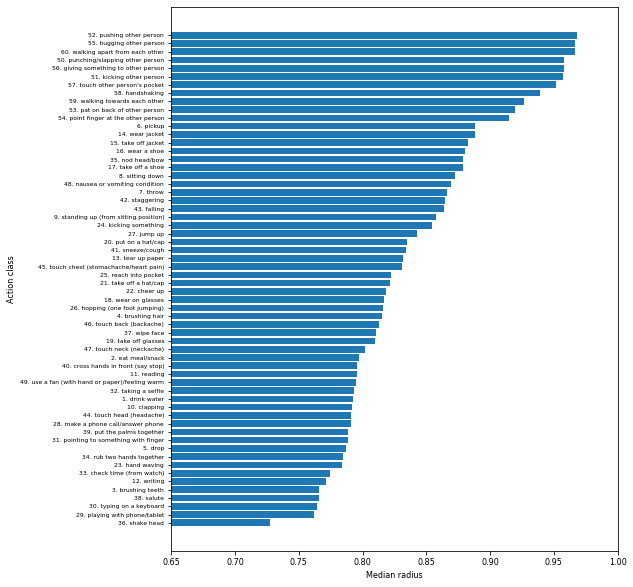

In [10]:
# plt.rcdefaults()
fig, ax = plt.subplots(figsize=(8, 10))
ax.barh(range(len(label_median_radii)), values, tick_label=names,
        align="center", )
ax.invert_yaxis()
ax.set_xlabel('Median radius', fontsize=8)
ax.set_ylabel('Action class', fontsize=8)
ax.tick_params(axis='y', labelsize=6)
ax.tick_params(axis='x', labelsize=8)
plt.xlim(0.65,1.0)
plt.savefig(f"{vis_dir}median_radii.pdf", bbox_inches='tight')
plt.show()

In [37]:
class_id = 8
        
radii, radii_idx = get_class_radii(class_id)
median_radius = round(np.median(radii), 4)
median_id, median_seq_radius = find_nearest(median_radius)
min_id, min_radius = radii_idx[radii.argmin()], round(radii[radii.argmin()], 4)
max_id, max_radius = radii_idx[radii.argmax()], round(radii[radii.argmax()], 4)
print(f"median radius = {median_radius}")
print(f"median sequence: {median_id} ({round(median_seq_radius, 4)})")
print(f"seq with min radius: {min_id} ({min_radius})")
print(f"seq with max radius: {max_id} ({max_radius})")

9. standing up (from sitting position)

median radius = 0.8538
median sequence: 2348 (0.8538)
seq with min radius: 2528 (0.8076)
seq with max radius: 1628 (0.8936)


Seq_id: 2528
Frames: [15, 25, 40]
Label: 9. standing up (from sitting position)
Radius: 0.8076
Save fig visualizations/9_standing_up_from_sitting_position__0_8076.pdf


[<Axes3DSubplot:>, <Axes3DSubplot:>, <Axes3DSubplot:>]

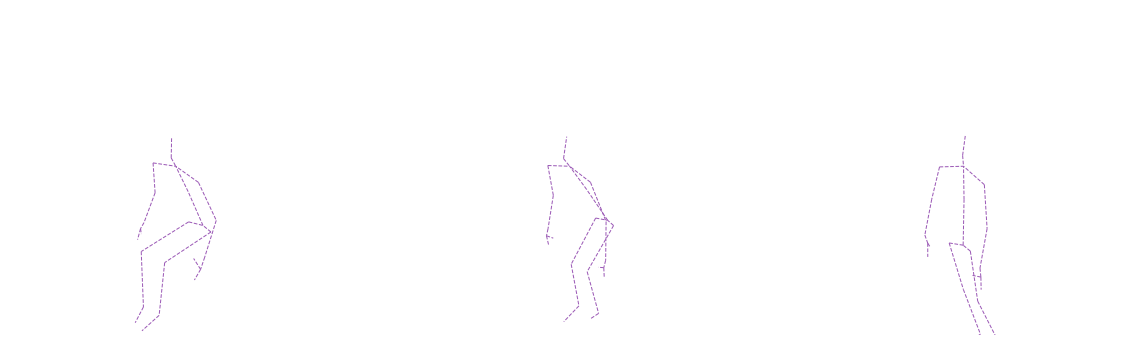

In [45]:
# class_id = 23
# seq_id = class_id + 60*4
seq_id = 2528  
print(f"Seq_id: {seq_id}")
frames = [15,25,40]
print(f"Frames: {frames}")
plot_sequence(seq_id, frames, True)

Label: 55. hugging other person
Radius: 0.9281
Save fig visualizations/55_hugging_other_person_0_9281.pdf
Label: 55. hugging other person
Radius: 0.9657
Save fig visualizations/55_hugging_other_person_0_9657.pdf
Label: 55. hugging other person
Radius: 0.9832
Save fig visualizations/55_hugging_other_person_0_9832.pdf


[<Axes3DSubplot:>, <Axes3DSubplot:>, <Axes3DSubplot:>]

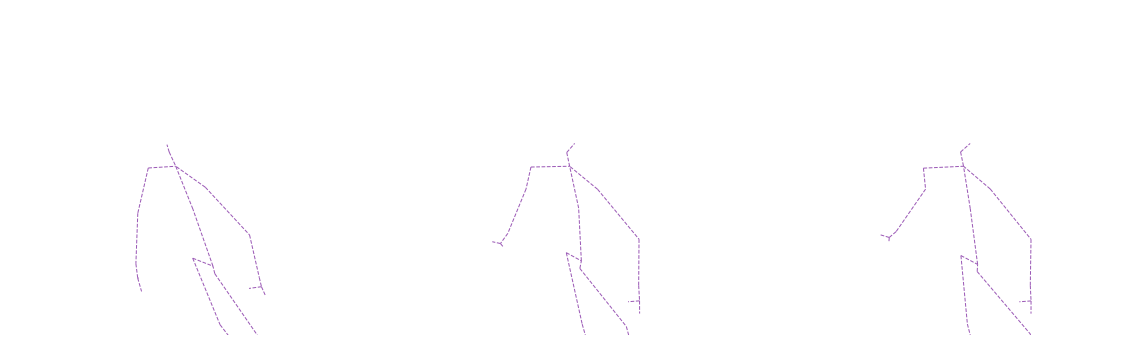

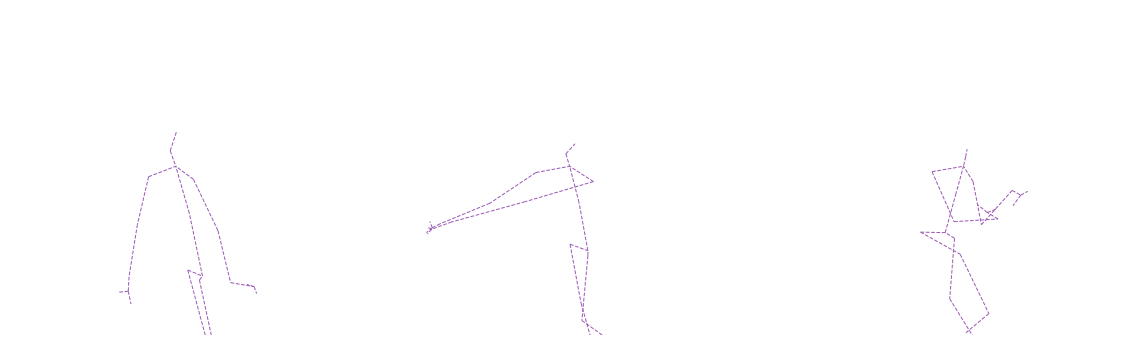

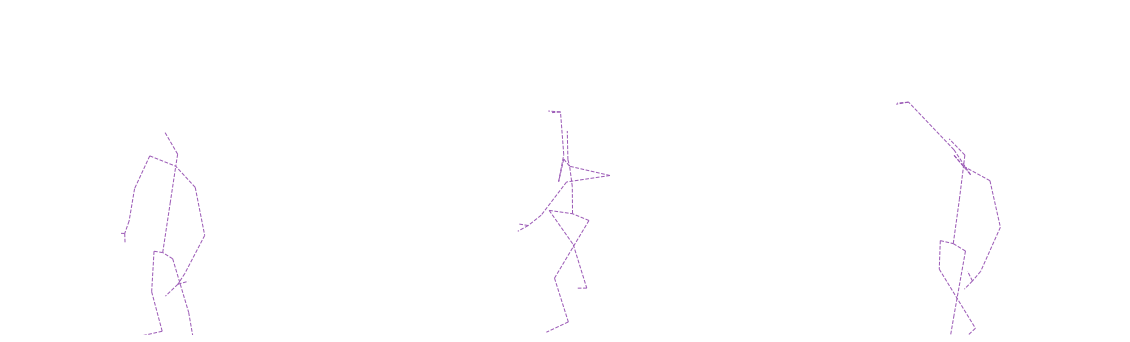

In [106]:
frames = [10, 25, 45]
save = True
plot_sequence(min_id, frames, save)
plot_sequence(avg_id, frames, save)
plot_sequence(max_id, frames, save)